## Figure 4

- Panel A: Coefficient plot for the non-organelle based features
- Panel B: Coefficient plot for the correlation features
- Panel C: Coefficient plot for the compartment based features

In [14]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(cowplot))

In [15]:
figure_dir <- "../figures"
output_main_figure_4 <- file.path(
    figure_dir, "main_figure_4_feature_importance.png"
)
results_dir <- file.path("../../1.train_models/train_deriv_model/coeff_results")

## Generate coefficient plot

In [16]:
# Load data
feat_import_file <- file.path(results_dir, "final_model_coefficients.csv")

feat_import_df <- read.csv(feat_import_file)

# Change the column names to be more descriptive
colnames(feat_import_df) <- c(
    "feature_names",
    "feature_importances"
)

dim(feat_import_df)
head(feat_import_df)

[1] 834   2

,feature_names,feature_importances
,<chr>,<dbl>
1,Cytoplasm_RadialDistribution_ZernikePhase_GFP_9_3,0.072248004
2,Cytoplasm_RadialDistribution_ZernikeMagnitude_GFP_9_1,-0.140595704
3,Cytoplasm_RadialDistribution_ZernikePhase_CY5_7_5,0.001740666
4,Nuclei_RadialDistribution_ZernikePhase_DAPI_5_1,0.017364311
5,Nuclei_RadialDistribution_ZernikeMagnitude_GFP_9_9,-0.024398764
6,Cells_RadialDistribution_MeanFrac_GFP_2of4,0.102912680


In [17]:
# Split out components of feature name for visualization
feat_import_df <- feat_import_df %>%
    dplyr::arrange(desc(abs(feature_importances))) %>%
    tidyr::separate(
        feature_names,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2",
            "parameter3"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel) %>%
    dplyr::mutate(parameter1_cleaned = parameter1)

# Convert the feature_importances to the absolute value
feat_import_df <- feat_import_df %>%
  mutate(feature_importances = abs(feature_importances))

feat_import_df$channel_cleaned <- dplyr::recode(feat_import_df$channel_cleaned,
    "DAPI" = "Nucleus",
    "GFP" = "ER",
    "RFP" = "Actin",
    "CY5" = "Mito",
    .default = "other",
    .missing = "other"
)

feat_import_df$parameter1_cleaned <- dplyr::recode(feat_import_df$parameter1_cleaned,
    "DAPI" = "Nucleus",
    "GFP" = "ER",
    "RFP" = "Actin",
    "CY5" = "Mito",
    .default = "other",
    .missing = "other"
)


print(dim(feat_import_df))
head(feat_import_df, 3)

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 748 rows [1, 2, 3, 4, 5,
8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, ...].”


[1] 834  11


,feature_names,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,feature_importances,channel_cleaned,parameter1_cleaned
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,Nuclei_RadialDistribution_FracAtD_DAPI_4of4,Nuclei,RadialDistribution,FracAtD,DAPI,4of4,NA,NA,2.181626,Nucleus,other
2,Nuclei_RadialDistribution_FracAtD_RFP_4of4,Nuclei,RadialDistribution,FracAtD,RFP,4of4,NA,NA,1.992575,Actin,other
3,Cytoplasm_Intensity_IntegratedIntensityEdge_DAPI,Cytoplasm,Intensity,IntegratedIntensityEdge,DAPI,NA,NA,NA,1.626386,Nucleus,other


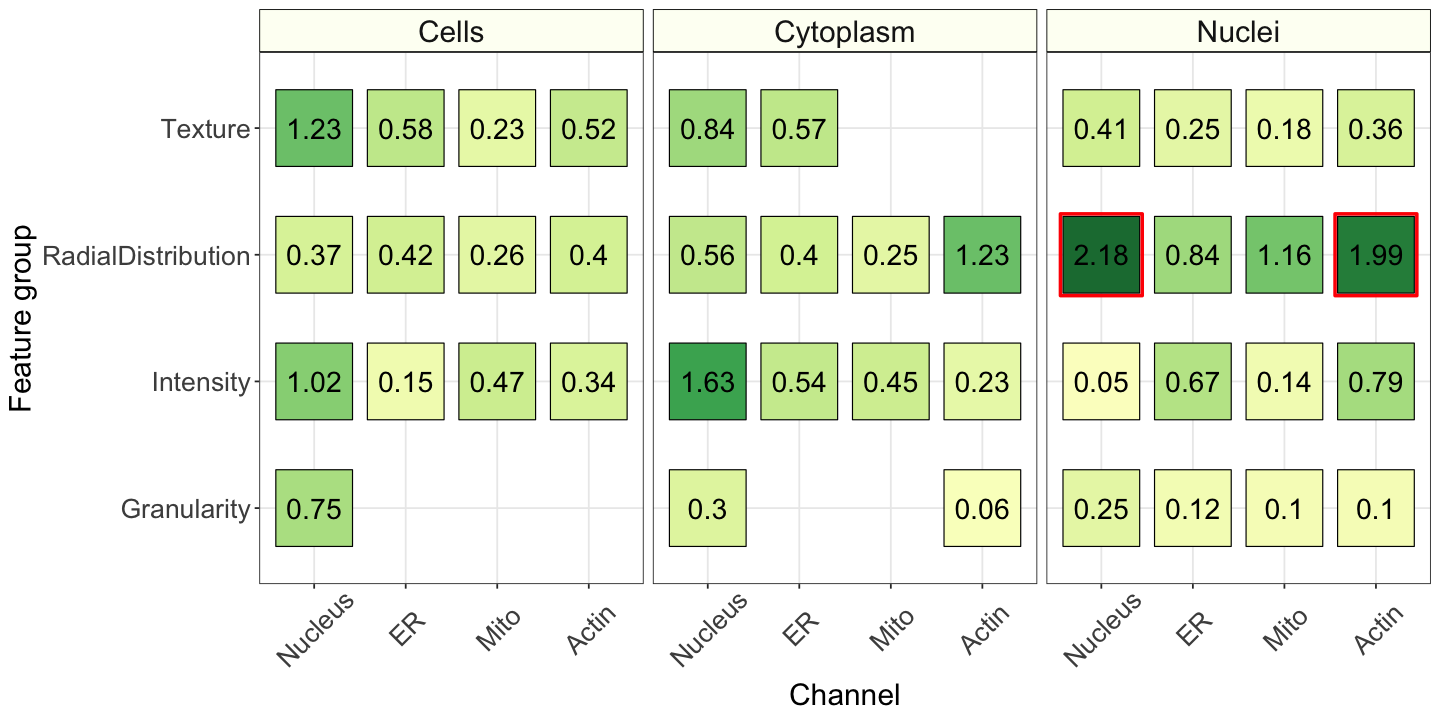

In [18]:
channels <- c(
    "Mito" = "Mito",
    "Nucleus" = "DNA",
    "ER" = "ER",
    "Actin" = "Actin",
    "other" = "other"
)

# Find top feature
top_feat_import_df <- feat_import_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

# Add rounded coefficient values to the data frame
top_feat_import_df <- top_feat_import_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Reorder the channel_cleaned factor levels
channel_order <- c("Nucleus", "ER", "Mito", "Actin", "other")
top_feat_import_df <- top_feat_import_df %>%
    mutate(channel_cleaned = factor(channel_cleaned, levels = channel_order))

# Process data for plotting
other_feature_group_df <- top_feat_import_df %>%
    dplyr::filter(!feature_group %in% c("AreaShape", "Correlation", "Neighbors", "Location"))

# Create a new data frame for the red box around the nuclei radial disbribution in the nuclei compartment
red_box_nuclei_radial <- other_feature_group_df %>%
    dplyr::filter(channel_cleaned == "Nucleus" & feature_group == "RadialDistribution" & compartment == "Nuclei")

# Create a new data frame for the red box around the mito radial disbribution in the nuclei compartment
red_box_mito_radial <- other_feature_group_df %>%
    dplyr::filter(channel_cleaned == "Actin" & feature_group == "RadialDistribution" & compartment == "Nuclei")

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot with stars for Actin and RadialDistribution, and ER and Intensity in the Cytoplasm facet
feature_importance_gg <- (
    ggplot(other_feature_group_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 24)
    + geom_text(aes(label = rounded_coeff), size = 6)
    + geom_point(data = red_box_nuclei_radial,
                aes(x = channel_cleaned, y = feature_group),
                color = "red",
                shape = 0,
                size = 22,
                stroke = 1.5) # Red box for Nuclei and RadialDistribution
    + geom_point(data = red_box_mito_radial,
                aes(x = channel_cleaned, y = feature_group),
                color = "red",
                shape = 0,
                size = 22,
                stroke = 1.5) # Red box for Nuclei and RadialDistribution
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top abs value\ncoefficient",
        palette = "YlGn",
        direction = 1,
        limits = c(0, 2.5)
    )
    + xlab("Channel")
    + ylab("Feature group")
    + theme(
        axis.text = element_text(size = 16),
        axis.text.x = element_text(angle = 45, size = 16, vjust = 0.6, hjust = 0.5),
        axis.title = element_text(size = 18),
        strip.text = element_text(size = 18),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none", # Move legend to bottom
        legend.title = element_text(size = 16), # Increase space between title and gradient
        legend.text = element_text(size = 14),
        legend.key.height = unit(1.25, "cm"), # Increase height of legend key
        legend.key.width = unit(1.5, "cm"), # Optionally, increase width of legend key
        legend.margin = margin(t = 35),
    )
)

feature_importance_gg

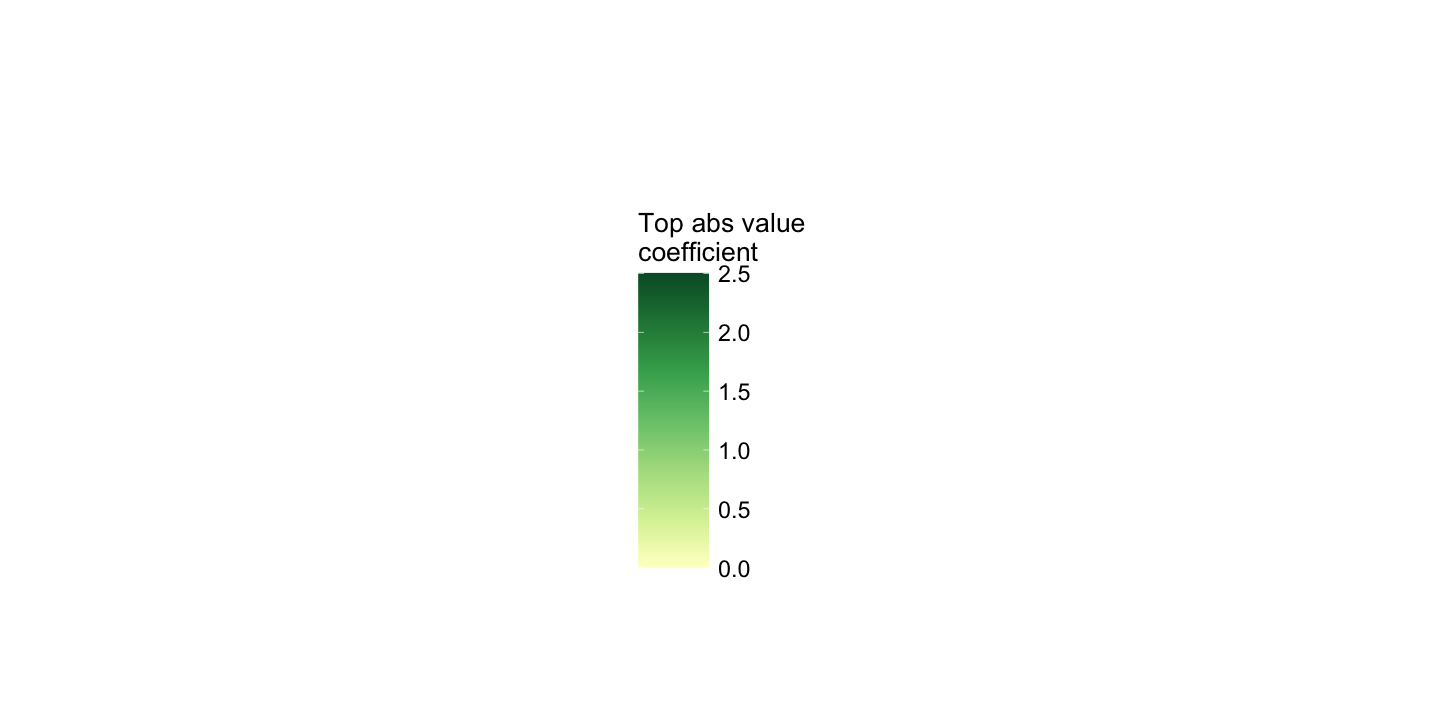

In [19]:
# Extract the legend as a separate grob
legend <- cowplot::get_legend(
  feature_importance_gg + theme(legend.position = "right")
)

cowplot::plot_grid(legend)

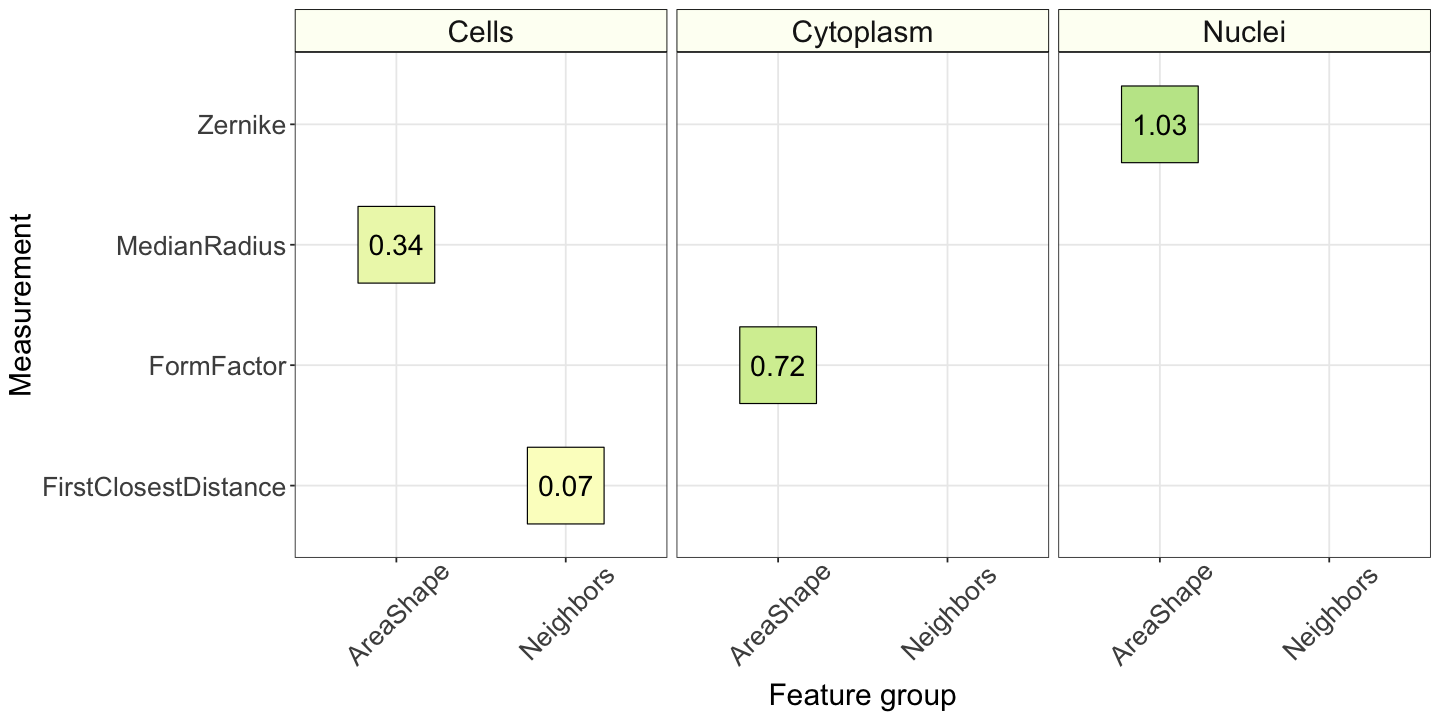

In [20]:
# Filter data to include AreaShape and Neighbors feature groups
area_shape_neighbors_df <- feat_import_df %>%
    dplyr::filter(feature_group %in% c("AreaShape", "Neighbors", "Location")) %>%
    dplyr::mutate(area_shape_indicator = paste(measurement, channel, parameter1, sep = "_"))

# Add rounded coefficient values to the data frame
area_shape_neighbors_df <- area_shape_neighbors_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Find top feature per measurement
top_area_shape_neighbors_df <- area_shape_neighbors_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
areashape_neighbors_importance_gg <- (
    ggplot(top_area_shape_neighbors_df, aes(x = feature_group, y = measurement))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 24)
    + geom_text(aes(label = rounded_coeff), size = 6)
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top absolute\nvalue weight\nfrom model",
        palette = "YlGn",
        direction = 1,
        limits = c(0, 4)
    )
    + xlab("Feature group")
    + ylab("Measurement")
    + theme(
        axis.text = element_text(size = 16),
        axis.text.x = element_text(angle = 45, size = 16, vjust = 0.6, hjust = 0.5),
        axis.title = element_text(size = 18),
        strip.text = element_text(size = 18),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none"
    )
)

areashape_neighbors_importance_gg

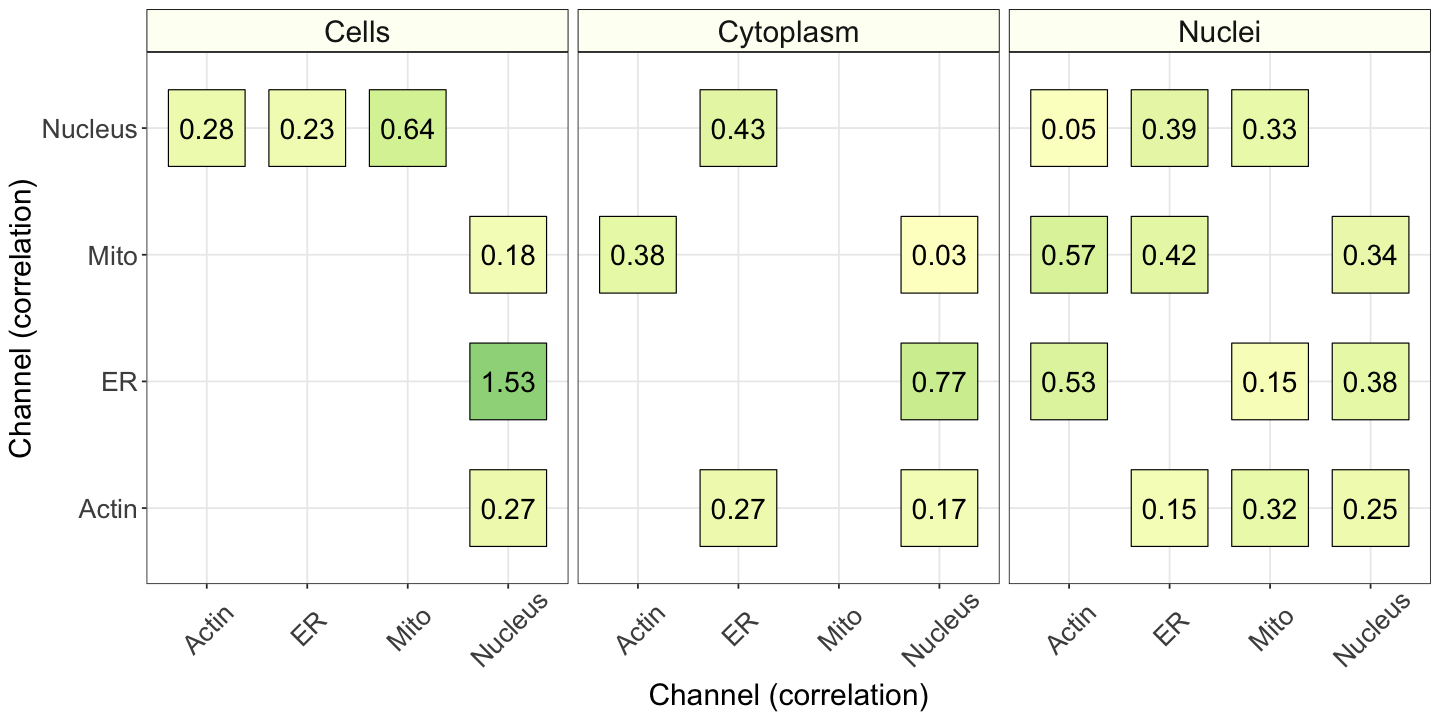

In [21]:
correlation_df <- feat_import_df %>% dplyr::filter(feature_group  == "Correlation")

# Add rounded coefficient values to the data frame
correlation_df <- correlation_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Find top feature per channel combo
top_correlation_df <- correlation_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment, channel, parameter1) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
correlation_importance_gg <- (
    ggplot(top_correlation_df, aes(x = channel_cleaned, y = parameter1_cleaned))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 24)
    + geom_text(aes(label = rounded_coeff), size = 6)
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top absolute\nvalue weight\nfrom model",
        palette = "YlGn",
        direction = 1,
        limits = c(0, 4)
    )
    + xlab("Channel (correlation)")
    + ylab("Channel (correlation)")
    + theme(
        axis.text = element_text(size = 16),
        axis.text.x = element_text(angle = 45, size = 16, vjust = 0.6, hjust = 0.5),
        axis.title = element_text(size = 18),
        strip.text = element_text(size = 18),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none"
    )
)

correlation_importance_gg

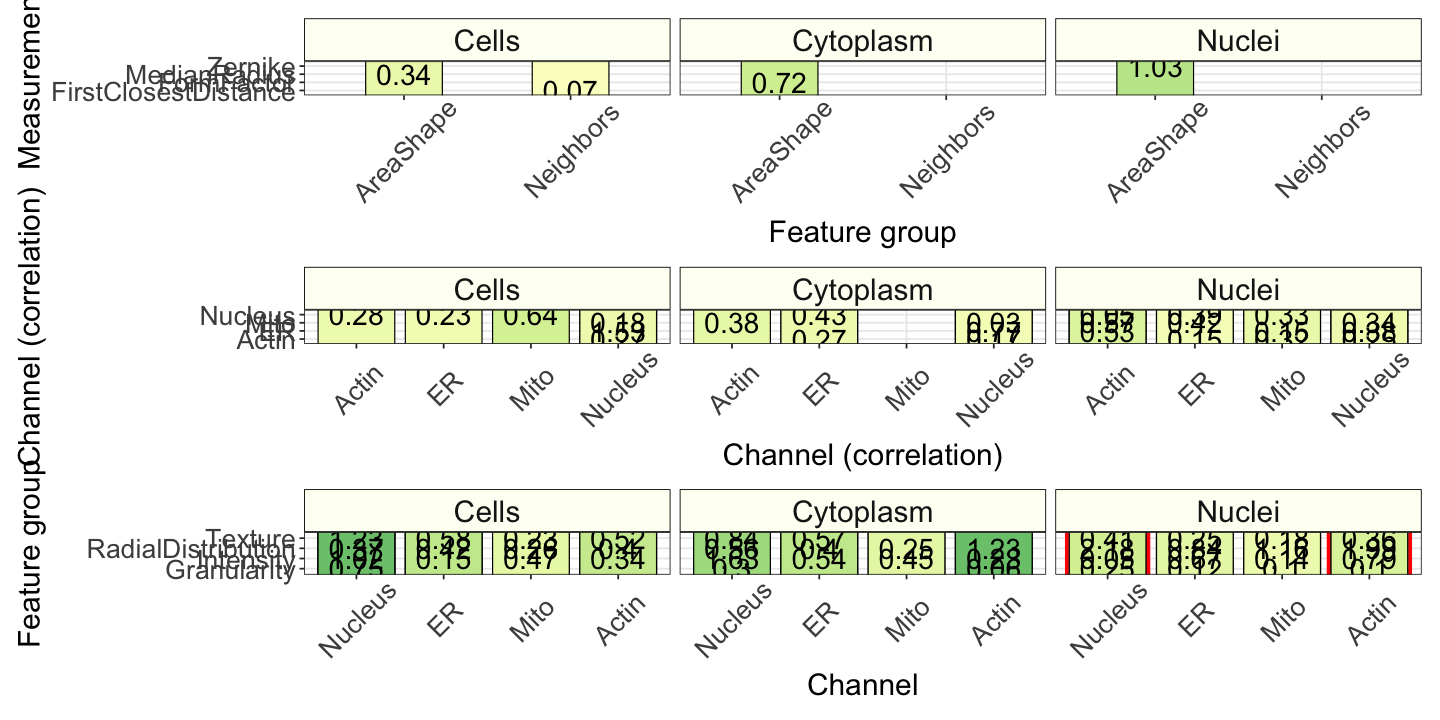

In [22]:
coefficient_plot <- (
    areashape_neighbors_importance_gg /
    correlation_importance_gg /
    feature_importance_gg
) + plot_layout(heights = c(1,1,1.25))

coefficient_plot

## Generate main figure 4 

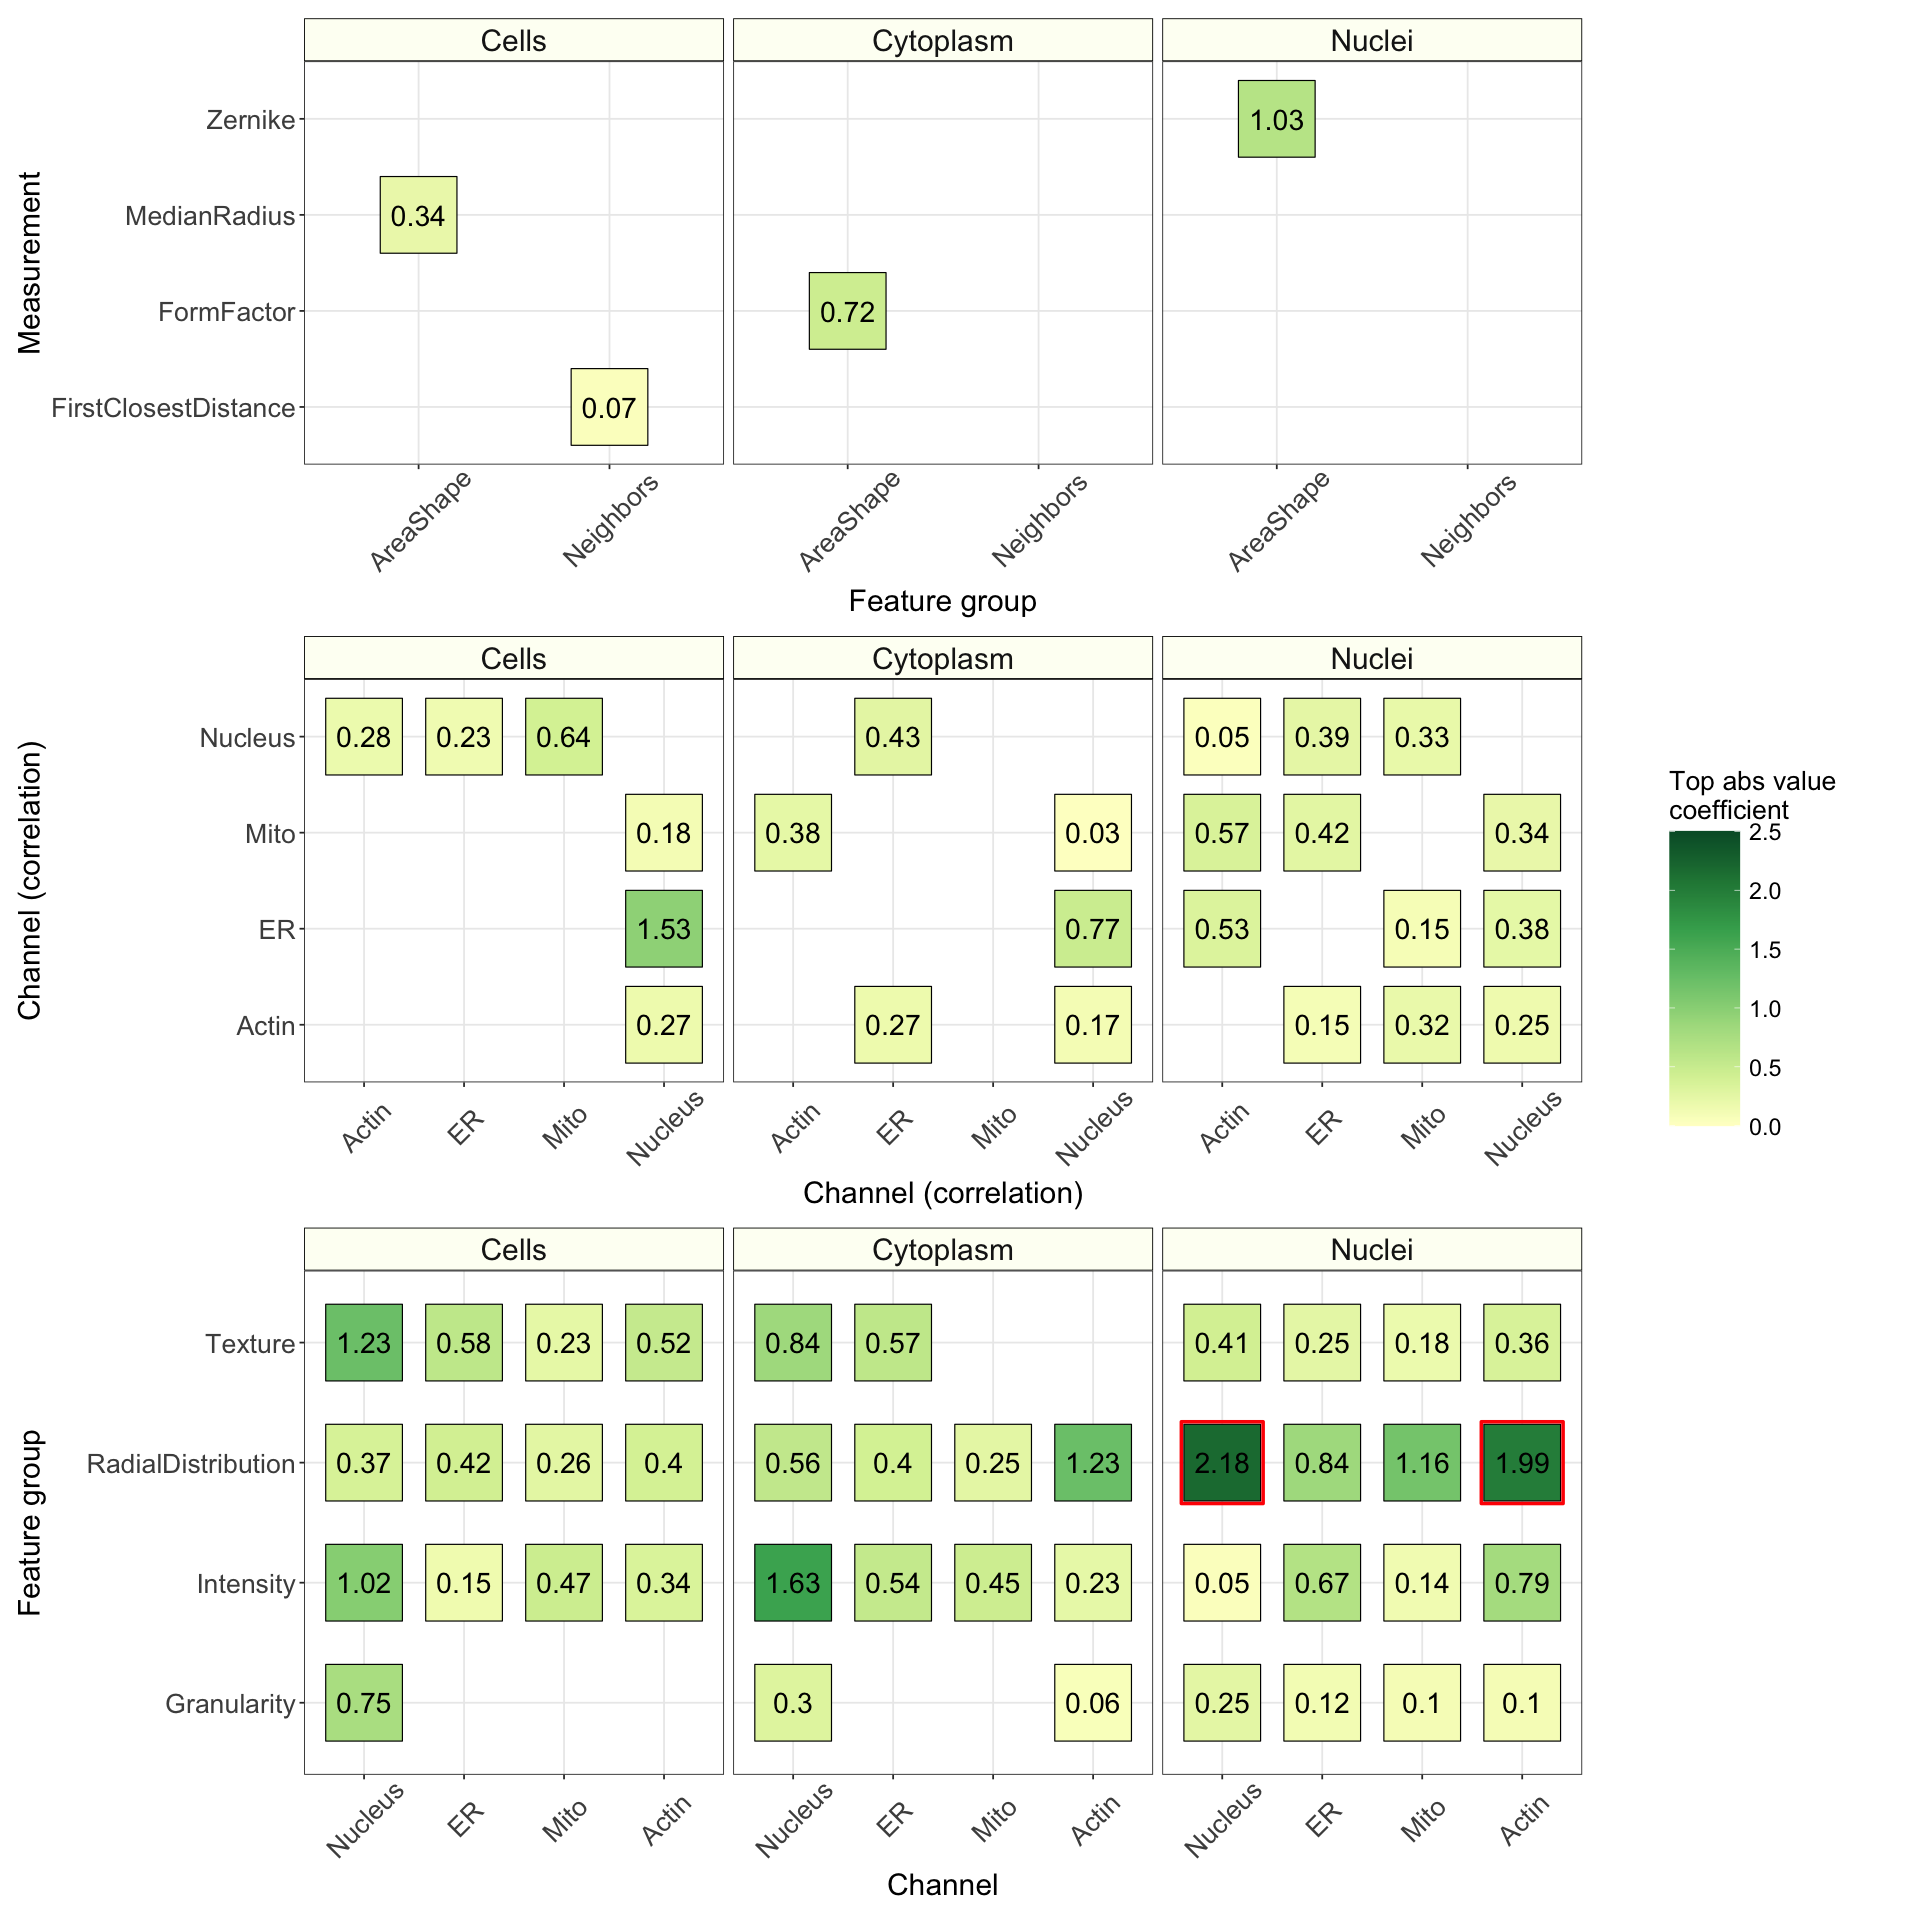

In [23]:
width <- 16
height <- 16

options(repr.plot.width = width, repr.plot.height = height)

fig_4_gg <- (
    coefficient_plot | 
    cowplot::plot_grid(legend, nrow = 1)
) + plot_layout(widths = c(4, 1))

# Save or display the plot
ggsave(output_main_figure_4, plot = fig_4_gg, dpi = 500, height = height, width = width)

fig_4_gg